In [40]:
# Import PyTorch
import torch
from torch import nn
import torch_directml

# Import torchvision
import torchvision
from torchvision import transforms

# Import matplotlib for visualization
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup device-agnostic code
device = torch_directml.device() if torch_directml.is_available() else 'cpu'
device

device(type='privateuseone', index=0)

In [3]:
from pathlib import Path

## Defining batch specfications
batch_size = 32
img_height = 250
img_width = 250

# Define train & test directories
train_dir = Path('data/train')
test_dir = Path('data/test')
val_dir = Path('data/val')

In [4]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize  our images to 250x250
    transforms.Resize(size=(img_height,img_width)),

    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [5]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transform for the data
                                  target_transform=None) # Transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

val_data = datasets.ImageFolder(root=val_dir,
                                 transform=data_transform)

train_data, test_data, val_data

(Dataset ImageFolder
     Number of datapoints: 791
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 100
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 98
     Root location: data\val
     StandardTransform
 Transform: Compose(
                Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [6]:
# Get class names as a list
class_names = train_data.classes
class_names

['Accident', 'Non Accident']

In [7]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'Accident': 0, 'Non Accident': 1}

In [8]:
# Check the length of our dataset
len(train_data), len(test_data)

(791, 100)

In [9]:
train_data.samples[0]

('data\\train\\Accident\\acc1 (1).jpg', 0)

Original shape: torch.Size([3, 250, 250]) -> [color_channels, height, width]
Permuted shape: torch.Size([250, 250, 3]) -> [height, width, color_channels]


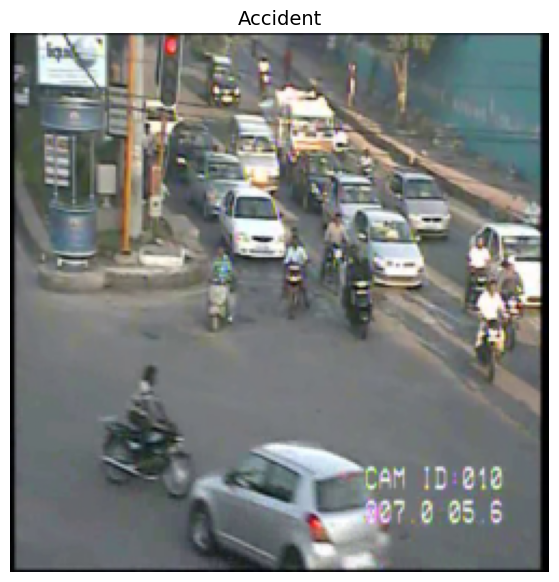

In [10]:
# Rearrange the order of dimensions
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Permuted shape: {img_permute.shape} -> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label],fontsize=14);

In [11]:
# Turn train & test datasets into DataLoader's
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=0,
                             shuffle=False)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle=False)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2bcb3105c60>,
 <torch.utils.data.dataloader.DataLoader at 0x2bccbc73820>)

In [12]:
# Number of batches in each dataloader
len(train_dataloader), len(test_dataloader), len(val_dataloader)

(25, 4, 4)

In [13]:
len(train_data), len(test_data), len(val_data)

(791, 100, 98)

In [14]:
img, label = next(iter(train_dataloader))

# Batch size will now be 128, you can change the batch size if you like
print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([32, 3, 250, 250]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [15]:
class CrashCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn = nn.BatchNorm2d(
            num_features=3
        )
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=43264,
                out_features=512
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=512,
                out_features=2,
            )
        )

    def forward(self,x):
        x = self.bn(x)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.classifier(x)

        return x
        # return self.classifier(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(self.batch_norm(x)))))) # benefits from operator fusion
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [16]:
model = CrashCNN().to(device)
model

CrashCNN(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=512, bias=T

In [17]:
from torchinfo import summary

summary(model=model,
        input_size=[128,3,250,250],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CrashCNN (CrashCNN)                      [128, 3, 250, 250]   [128, 2]             --                   True
├─BatchNorm2d (bn)                       [128, 3, 250, 250]   [128, 3, 250, 250]   6                    True
├─Sequential (conv_block_1)              [128, 3, 250, 250]   [128, 32, 124, 124]  --                   True
│    └─Conv2d (0)                        [128, 3, 250, 250]   [128, 32, 248, 248]  896                  True
│    └─ReLU (1)                          [128, 32, 248, 248]  [128, 32, 248, 248]  --                   --
│    └─MaxPool2d (2)                     [128, 32, 248, 248]  [128, 32, 124, 124]  --                   --
├─Sequential (conv_block_2)              [128, 32, 124, 124]  [128, 64, 61, 61]    --                   True
│    └─Conv2d (0)                        [128, 32, 124, 124]  [128, 64, 122, 122]  18,496               True
│    └─ReLU (1)   

In [18]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put the model in train mode
    model.train()

    # Setup train loss & train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # Output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

    # Adjust metrics to get average loss & accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [19]:
# Create test_step()
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device = device):
    # Put the model in eval mode
    model.eval()

    # Setup test loss & test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.no_grad():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss & accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # 3. Loop through training & testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out what's happening
        print(f' Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

        # 5. Update the results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\tshar\anaconda3\envs\DirectML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
num_epochs = 20

# Recreate an instance of TinyVGG
model = CrashCNN().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=num_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [01:29<28:22, 89.60s/it]

 Epoch: 0 | Train loss: 0.7412 | Train acc: 0.5456 | Test loss: 0.6698 | Test acc: 0.6641


 10%|█         | 2/20 [02:42<23:57, 79.84s/it]

 Epoch: 1 | Train loss: 0.6546 | Train acc: 0.6078 | Test loss: 0.5472 | Test acc: 0.7578


 15%|█▌        | 3/20 [04:01<22:26, 79.23s/it]

 Epoch: 2 | Train loss: 0.6018 | Train acc: 0.6901 | Test loss: 0.4625 | Test acc: 0.8047


 20%|██        | 4/20 [05:27<21:51, 81.96s/it]

 Epoch: 3 | Train loss: 0.5061 | Train acc: 0.7488 | Test loss: 0.3075 | Test acc: 0.8438


 25%|██▌       | 5/20 [06:58<21:19, 85.32s/it]

 Epoch: 4 | Train loss: 0.4095 | Train acc: 0.8143 | Test loss: 0.2767 | Test acc: 0.8594


 30%|███       | 6/20 [08:24<19:57, 85.57s/it]

 Epoch: 5 | Train loss: 0.3128 | Train acc: 0.8762 | Test loss: 0.2962 | Test acc: 0.8750


 35%|███▌      | 7/20 [09:50<18:33, 85.68s/it]

 Epoch: 6 | Train loss: 0.2195 | Train acc: 0.9083 | Test loss: 0.1734 | Test acc: 0.9453


 40%|████      | 8/20 [11:19<17:21, 86.80s/it]

 Epoch: 7 | Train loss: 0.1657 | Train acc: 0.9448 | Test loss: 0.2311 | Test acc: 0.9062


 45%|████▌     | 9/20 [13:02<16:51, 91.93s/it]

 Epoch: 8 | Train loss: 0.1564 | Train acc: 0.9483 | Test loss: 0.1383 | Test acc: 0.9297


 50%|█████     | 10/20 [14:38<15:29, 92.92s/it]

 Epoch: 9 | Train loss: 0.1478 | Train acc: 0.9437 | Test loss: 0.1649 | Test acc: 0.9297


 55%|█████▌    | 11/20 [16:04<13:38, 90.93s/it]

 Epoch: 10 | Train loss: 0.0951 | Train acc: 0.9658 | Test loss: 0.1360 | Test acc: 0.9375


 60%|██████    | 12/20 [17:30<11:55, 89.41s/it]

 Epoch: 11 | Train loss: 0.0878 | Train acc: 0.9753 | Test loss: 0.1224 | Test acc: 0.9453


 65%|██████▌   | 13/20 [18:55<10:17, 88.24s/it]

 Epoch: 12 | Train loss: 0.0542 | Train acc: 0.9800 | Test loss: 0.1219 | Test acc: 0.9375


 70%|███████   | 14/20 [20:21<08:45, 87.53s/it]

 Epoch: 13 | Train loss: 0.0436 | Train acc: 0.9808 | Test loss: 0.1132 | Test acc: 0.9453


 75%|███████▌  | 15/20 [21:47<07:15, 87.08s/it]

 Epoch: 14 | Train loss: 0.0432 | Train acc: 0.9803 | Test loss: 0.1225 | Test acc: 0.9531


 80%|████████  | 16/20 [23:14<05:47, 86.93s/it]

 Epoch: 15 | Train loss: 0.0545 | Train acc: 0.9788 | Test loss: 0.1079 | Test acc: 0.9297


 85%|████████▌ | 17/20 [24:40<04:20, 86.68s/it]

 Epoch: 16 | Train loss: 0.0453 | Train acc: 0.9845 | Test loss: 0.2003 | Test acc: 0.9531


 90%|█████████ | 18/20 [26:05<02:52, 86.23s/it]

 Epoch: 17 | Train loss: 0.0753 | Train acc: 0.9762 | Test loss: 0.1310 | Test acc: 0.9375


 95%|█████████▌| 19/20 [27:31<01:26, 86.05s/it]

 Epoch: 18 | Train loss: 0.0519 | Train acc: 0.9800 | Test loss: 0.2451 | Test acc: 0.9219


100%|██████████| 20/20 [28:57<00:00, 86.85s/it]

 Epoch: 19 | Train loss: 0.0374 | Train acc: 0.9862 | Test loss: 0.1639 | Test acc: 0.9453
Total training time: 1737.036 seconds


In [22]:
def plot_loss_curves(results):
    '''Plots training curves of a results dictionary.'''
    # Get the loss values of the results dictionary (train & tes)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (train & test)
    acc = results['train_acc']
    test_acc = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_acc']))

    # setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,label='train_acc')
    plt.plot(epochs,test_acc,label='test_acc')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

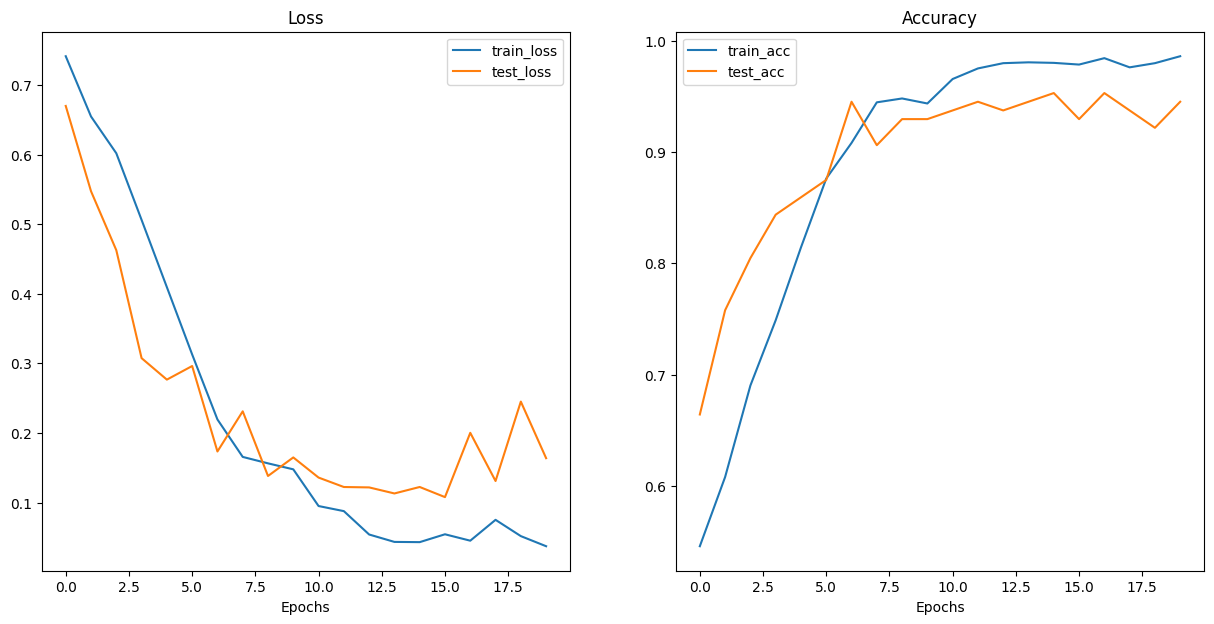

In [23]:
plot_loss_curves(model_results)

In [27]:
#Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'crash_cnn.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dictionary (Recommended)
print(f"Saving model to: {MODEL_SAVE_PATH}")
model.cpu()
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models\crash_cnn.pth


In [25]:
# To load in a saved state_dict we have to instantiate a new instance of our model clas
loaded_model = CrashCNN()
print(loaded_model.state_dict())

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
print(loaded_model.state_dict())

OrderedDict([('bn.weight', tensor([1., 1., 1.])), ('bn.bias', tensor([0., 0., 0.])), ('bn.running_mean', tensor([0., 0., 0.])), ('bn.running_var', tensor([1., 1., 1.])), ('bn.num_batches_tracked', tensor(0)), ('conv_block_1.0.weight', tensor([[[[ 0.1417, -0.1903,  0.1563],
          [-0.0373,  0.1924, -0.0954],
          [ 0.1493,  0.0090, -0.1311]],

         [[ 0.1116,  0.1142, -0.1381],
          [-0.1575, -0.1172, -0.1564],
          [ 0.1093, -0.0138,  0.0194]],

         [[ 0.0784, -0.0355,  0.1889],
          [ 0.0770, -0.0894,  0.1438],
          [-0.1327, -0.0347, -0.0948]]],


        [[[-0.1179,  0.0042, -0.0397],
          [-0.1624,  0.0113,  0.0282],
          [ 0.0103, -0.0871,  0.1753]],

         [[-0.1904, -0.0484, -0.0067],
          [-0.1455,  0.0417, -0.0142],
          [-0.1577,  0.0402,  0.1148]],

         [[-0.1518,  0.0750,  0.1675],
          [ 0.0456, -0.1387,  0.0178],
          [-0.1489, -0.0790, -0.1382]]],


        [[[-0.0816, -0.0556,  0.1011],
        

In [47]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names,
                        transform = None,
                        device = device):
    '''Makes a prediction on a target image with a trained model & plots the image & predictions.'''
    # Load the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0,1]
    target_image /= 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on target device
    model.to(device)

    # Turn on eval/inference mode & make a prediction
    model.eval()
    with torch.no_grad():
        # add an extra dimension to the image (this is the batch dimension, e.x. our model will predict on batches of 1x images)
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device)) # Make sure the target image is on the right device

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

    # Plot the image alongside the prediction & prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # removes batch dimensions & rearrange shape to be HWC
    if class_names:
        title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else:
        title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False);

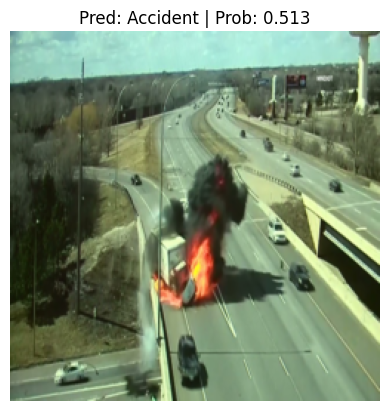

In [49]:
# Pred on our custom image
pred_and_plot_image(model=loaded_model,
                    image_path='test_image.jpg',
                    class_names=class_names,
                    transform=transforms.Resize(size=(img_height,img_width), antialias=True),
                    device=device)